In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.fftpack import fft, ifft
from scipy.signal import cwt, morlet
from pydmd import DMD
from pydmd.plotter import plot_eigs
# %matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import seaborn as sns
import pywt
from IPython.display import HTML
import scipy
from functools import partial

In [2]:
# pip install "git+https://github.com/cwrowley/dmdtools.git"

In [3]:
# Discretization
Xlngth = 10  # X Length of domain
Xnum = int(5e2)  # X number of cells
dx = Xlngth/Xnum  # X length between cells

kx = np.fft.fftfreq(Xnum, dx)  # Wave numbers in Fourier space

Tlngth = 5  # T length of time domain
snaps = 100  # number of snapshots
cursnap = 0

In [4]:
nmean = 3/(4*np.pi)
Gamma = 1
kappa = 1
therm_cond = 1
eta = 1

In [5]:
# Initialize domain
X = np.linspace(0,Xlngth,Xnum+1)[:-1]
Snap = np.linspace(0,Tlngth, num=snaps+1, endpoint=True)

# Initialize variables at cell centroids
n = np.zeros(Xnum)  # Density
v = np.zeros(Xnum)  # Velocity
e = np.zeros(Xnum)  # Temperature
phi = np.zeros(Xnum)  # Electrostatic Potential

# Initialize fluxes at cell faces
Fn = np.zeros(Xnum)
Fv = np.zeros(Xnum)
Fe = np.zeros(Xnum)

# Initialize storage of variables
ntot = np.stack([n]*(snaps+1))
vtot = np.stack([v]*(snaps+1))
etot = np.stack([e]*(snaps+1))
phitot = np.stack([phi]*(snaps+1))

In [6]:
# Create Initial Conditions
def def_IC(X, option, *args):
    if option == 'gaussian':
        # Gaussian Initial Condition
        mu = Xlngth / 2
        sigma = 0.2 * Xlngth
        initial_condition = np.exp(-((X - mu)**2) / (2 * sigma**2))/(sigma*np.sqrt(2*np.pi))

    elif option == 'hat':
        # Hat (Step) Function Initial Condition
        initial_condition = np.where((X >= 0.4 * Xlngth) & (X <= 0.6 * Xlngth), 1.0, 0.0)

    elif option == 'constant':
        # Constant Initial Condition
        initial_condition = np.ones(Xnum)

    elif option == 'random':
        # Random Initial Condition
        np.random.seed(123)  # Seed for reproducibility
        initial_condition = np.random.rand(Xnum)

    elif option == 'sinusoidal':
        # Sinusoidal Initial Condition (with frequency = 3)
        frequency = args[0]
        initial_condition = np.sin(2 * np.pi * frequency * X / Xlngth)
        
    elif option == 'zero':
        # Zero Initial Condition
        initial_condition = np.zeros(Xnum)

    else:
        raise ValueError("Invalid initial condition option")

    return initial_condition

def half_domain_shift(arr):
    return np.roll(arr, shift = int(Xnum/2), axis = -1)

In [7]:
# Initialize Initial Condition
prtrb_ampltd = [.1, .05, .025, .01]
n = nmean + prtrb_ampltd[1]*def_IC(X, "sinusoidal", 3) \
#     - prtrb_ampltd[2]*def_IC(X, "sinusoidal", 3) \
#     + prtrb_ampltd[2]*def_IC(X, "sinusoidal", 5) \
#     - prtrb_ampltd[2]*def_IC(X, "sinusoidal", 7) \
#     + prtrb_ampltd[2]*def_IC(X, "sinusoidal", 11) \
#     - prtrb_ampltd[1]*def_IC(X, "random")
        
v = 1 + prtrb_ampltd[0]*def_IC(X, "zero")
e = 1 + prtrb_ampltd[0]*def_IC(X, "zero")

# n = half_domain_shift(n)
# v = half_domain_shift(v)
# e = half_domain_shift(e)

ICs = (n, v, e)
ICs = np.concatenate(ICs)

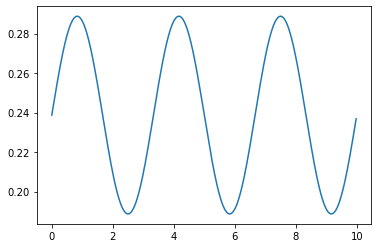

In [8]:
plt.plot(X,n)

In [9]:
# Define methods for retrieving neighbor elements
def l(arr):
    return np.roll(arr, shift=1, axis=-1)

def r(arr):
    return np.roll(arr, shift=-1, axis=-1)
    
def ddx(arr):
    return (arr-l(arr))/dx

def ddx_c(arr):
    return (r(arr)-l(arr))/(2*dx)

def d2dx2(arr):
    return (l(arr)-2*arr+r(arr))/dx

def thomas_algorithm(A, B, C, D):  # 100% Checked. With all randoms on all arrays. Seriously. Solid. Don't Touch.
    """
    Solve a tridiagonal matrix using the Thomas Algorithm.
    Mx = D
    
    Parameters:
    - A,B,C: 1D arrays that make up the subdiagonal, diagonal, and super diagonal nonzero elements of the tridiagonal matrix
                with shapes (Xnum-1,), (Xnum,), and (Xnum-1,), respectively.
    - x: 1D array meant to represent the input vector where x.shape=(Xnum,).
    - D: 1D array meant to represent the output vector where D.shape=(Xnum,).

    Returns:
    - x: vector solution
    """ 
    x = np.zeros(Xnum)    
    a, b, c, d = map(np.array, (A, B, C, D))
    
    # Forward elimination
    for i in range(0, Xnum-1):
        w = a[i] / b[i]
        b[i+1] -= w * c[i]
        d[i+1] -= w * d[i]

    # Backward substitution
    x[-1] = d[-1] / b[-1]
    for i in range(Xnum - 2, -1, -1):
        x[i] = (d[i] - c[i] * x[i + 1]) / b[i]
        
    return x    
    
def modified_thomas_algorithm(A, B, C, D):
    """ 
    Modified Thomas Algorithm to solve tridiagonal matrix with periodic boundary conditions.
    Use Shermann Morrison Theorem to find rank-1 perturbation to separate non tirdiagonal entries and solve using Thomas Algorithm
    """
    x = np.zeros(Xnum)
    
    a, b, c, d = map(np.array, (A, B, C, D))
    
    u = np.zeros(Xnum)
    v = np.zeros(Xnum)
    y = np.zeros(Xnum)
    q = np.zeros(Xnum)
    
    gamma_ta = 1  # Parameter chosen to reduce complexity of Shermann-Morrison Algorithm 
    c[-1] = 0  # Account for Gauge Invariance of Poisson Equation / Ensure invertibility of Laplacian with Periodic BC
    
    u[0] = gamma_ta
    u[-1] = c[-1]
    
    v[0] = 1
    v[-1] = a[0] / gamma_ta

    # Modify vectors A, B, and C
    Ba = a[1:]
    
    Bb = np.copy(b)
    Bb[0] -= gamma_ta
    Bb[-1] -= (c[-1] * a[0]) / gamma_ta
    
    Bc = c[:-1]
    
    y = thomas_algorithm(Ba, Bb, Bc, d)
    q = thomas_algorithm(Ba, Bb, Bc, u)

    Value = (v[0] * y[0] + v[-1] * y[-1]) / (1 + v[0] * q[0] + v[-1] * q[-1])
    
    x = y - q * Value
    
    return x

def solve_poisson(Xnum, n): # TODO: Fix Poisson
    """
    Special version of Thomas Algorithm from "Computer Simulation Using Particles" by Hockney and Eastwood pg. 35-39 and 185.
    When solving a Laplacian with periodic boundary conditions for a quantity with gauge invariance, this O(n) algorithm can be used.
    """
    phi = np.zeros(Xnum)

    p = np.arange(1, Xnum+1)
    
    phi[0] = np.sum(p *n) / Xnum

    phi[1] = n[0] + 2 * phi[0]

#     for jj in range(10):
    for ii in range(2, Xnum):
        phi[ii] = n[ii-1] + 2 * phi[ii-1] - phi[ii-2]
        
    return phi

# phi = solve_poisson(10,np.arange(10))
# print(phi)
# print(ddx(phi))



def DCF(r_prime, e, q, lambda_s):
    # Define DCF(r) using the given approximation with 1/e
    return np.exp(-(1 / e) * phi_r_prime(r_prime, q, lambda_s)) - 1

def phi_r_prime(r_prime, q, lambda_s):
    # Define phi(r') using the given formula
    return (q**2 / r_prime) * np.exp(-r_prime / lambda_s)

def correlation():
    corr = np.zeros(Xnum)

    for i in range(Xnum):
        r_prime = np.linspace(0, np.inf, Xnum)  # Discretize r' over [0, inf]
        integrand = (DCF(r_prime, e[i], q, lambda_s) / e[i]) * r_prime * np.sin(np.abs(kx[i]) * r_prime)
        corr[i] = 8 * np.pi**3 * ifft(1 / np.abs(kx[i]) * fft((n - nmean) * integrand)).real

def flux(t, y):
    n = y[:Xnum]  # Extract density component
    v = y[Xnum:2*Xnum]  # Extract velocity component
    e = y[2*Xnum:3*Xnum]  # Extract temperature component
    
    # [b1 c1 ...    a1]
    # [a2 b2 c2 ...  0]
    # [0  a3 b3 c3 ...]
    # [cn 0... an-1 bn]
    # Set cn = 0 to prevent singularity
    
    phimtx_sub = np.ones(Xnum)
    phimtx_diag = -2*np.ones(Xnum)
    phimtx_sup = np.ones(Xnum)
    phi_rhs = dx*dx*(-4*np.pi*(n-np.mean(n)))  # Found by substituting in nmean
    # phi_rhs = 3-4*np.pi* dx * dx * n
    phi = modified_thomas_algorithm(phimtx_sub, phimtx_diag, phimtx_sup, phi_rhs)
    # phi = solve_poisson(Xnum, 3-4*np.pi*n)
    
    flux_n = - ddx(n*v)
    flux_v = - ddx(0.5*v*v) - e*ddx(n)/n + eta/n*d2dx2(v) - Gamma*ddx(phi) # TODO: Fix phi
    flux_e = (therm_cond*ddx(e)-e*v)*ddx(n)/n - 2*v*ddx(e) + therm_cond*d2dx2(e)
    flux_sys = np.concatenate((flux_n, flux_v, flux_e))
    
    ### TODO: NOTE TO MURILLO: Choice of Gauge Invariance Changes Solution. cn = 0 or a1 = 0 leads to reverse ordering in solution
    
    ### Error: cursnap referenced before assignment ###
#     if t >= Snap[cursnap]:
#         print(round(100*t/Tlngth,2),"%")
#         cursnap += 1
    
    return flux_sys

In [10]:
# Test ###
# Xnum = 5
# A = np.ones(Xnum)  # Changed A to ones
# B = -2.0 * np.ones(Xnum)  # Changed B to negative twos
# C = np.ones(Xnum)  # Changed C to ones
# D = np.ones(Xnum)

# mtx = np.diag(A[1:], k=-1) + np.diag(B) + np.diag(C[:-1], k=1)
# mtx[0,-1] = 0
# mtx[-1,0] = 1

# mtx1 = np.diag(A[1:], k=-1) + np.diag(B) + np.diag(C[:-1], k=1)
# mtx1[-2,-1] = 0
# mtx1[-1,-1] = 0
# mtx1[0,-1] = 0
# mtx1[-1,0] = 1

# print(mtx1)

# # x_ta = thomas_algorithm(A,B,C,D)
# # print(x_ta)

# x_ta = modified_thomas_algorithm(A,B,C,D)
# print("x_ta", x_ta)

# x = np.linalg.solve(mtx,D)
# print("x", x)

# x_p = periodic_laplacian(D)
# print("x_p", x_p)

# # x = np.linalg.solve(mtx1,D[:-1])
# # x = np.append(x,0)
# # print(x)

# x_p = solve_poisson(Xnum, D)
# print("x_p", x_p)

# print("mtx*x", mtx@x)
# print("mtx*x_ta", mtx@x_ta)
# print("mtx1*x_p", mtx1@x_p)

# # print(mtx@x_ta)
# # print(D)
# # print(x)
# # print((x_ta - x)[0:10])
# # print(np.linalg.norm(x_ta-x))

# np.sum(3-4*np.pi*n)

In [11]:
# Solve PDEs
# sol = solve_ivp(fun=flux, t_span=[0,Tlngth], y0=ICs, method='Radau', t_eval=Snap)
sol = solve_ivp(fun=flux, t_span=[0,Tlngth], y0=ICs, t_eval=Snap)
# sol = solve_ivp(fun=flux, t_span=[0,Tlngth], y0=ICs)
# solc = solve_ivp(fun=flux_c, t_span=[0,Tlngth], y0=ICs, t_eval=Snap)

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 10604
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
       1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 ,
       1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05, 2.1 , 2.15,
       2.2 , 2.25, 2.3 , 2.35, 2.4 , 2.45, 2.5 , 2.55, 2.6 , 2.65, 2.7 ,
       2.75, 2.8 , 2.85, 2.9 , 2.95, 3.  , 3.05, 3.1 , 3.15, 3.2 , 3.25,
       3.3 , 3.35, 3.4 , 3.45, 3.5 , 3.55, 3.6 , 3.65, 3.7 , 3.75, 3.8 ,
       3.85, 3.9 , 3.95, 4.  , 4.05, 4.1 , 4.15, 4.2 , 4.25, 4.3 , 4.35,
       4.4 , 4.45, 4.5 , 4.55, 4.6 , 4.65, 4.7 , 4.75, 4.8 , 4.85, 4.9 ,
       4.95, 5.  ])
 t_events: None
        y: array([[0.23873241, 0.23412793, 0.22989664, ..., 0.2376351 , 0.23954697,
        0.24156211],
       [0.24061692, 0

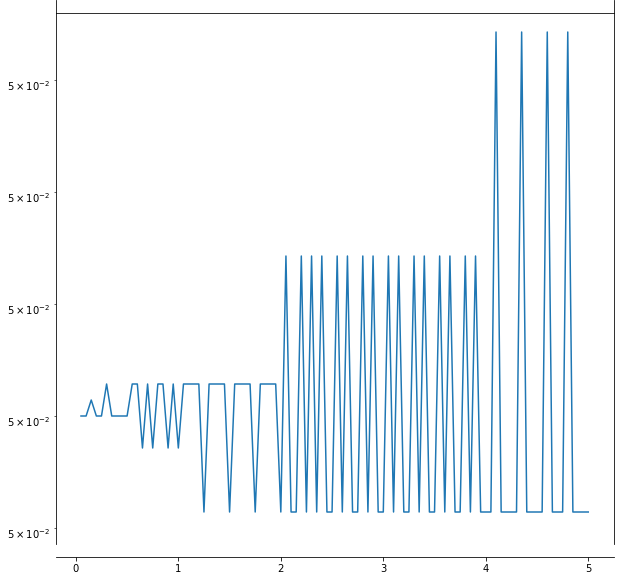

In [12]:
ntot = sol.y[:Xnum].reshape(Xnum, -1)
vtot = sol.y[Xnum:2*Xnum].reshape(Xnum, -1)
etot = sol.y[2*Xnum:].reshape(Xnum, -1)

T = sol.t

# nctot = solc.y[:Xnum].reshape(Xnum, -1)
# vctot = solc.y[Xnum:2*Xnum].reshape(Xnum, -1)
# ectot = solc.y[2*Xnum:].reshape(Xnum, -1)

# Tc = solc.t

print(sol)

time_steps = np.linspace(0,T.max(),len(T))

# print(T)

plt.figure(figsize=(10,10))
plt.semilogy(time_steps[1:], (T-l(T))[1:])

### 4 pi q^2 n_0 / m = w_p ###

In [13]:
print(len(ntot))
print(len(ntot[0]))

500
101


In [ ]:
# Line Plots
subplot_figsize = (30,10)
single_plot_figsize = (10,10)
num_time_plots = np.arange(0,len(T))

fig, ax = plt.subplots(1,3, figsize=subplot_figsize)

ax[0].plot(X,ntot[:,num_time_plots])
ax[0].set_title("Density", fontsize=24)
ax[0].set_xlabel("Space", fontsize=20)
ax[0].set_ylabel("Density", fontsize=20)

ax[1].plot(X,vtot[:,num_time_plots])
ax[1].set_title("Velocity", fontsize=24)
ax[1].set_xlabel("Space", fontsize=20)
ax[1].set_ylabel("Velocity", fontsize=20)

ax[2] = plt.plot(X,etot[:,num_time_plots])
# ax[2].set_title("Temperature")
# ax[2].set_xlabel("Space")
# ax[2].set_ylabel("Temperature")

plt.title("Temperature", fontsize=24)
plt.xlabel("Space", fontsize=20)
plt.ylabel("Temperature", fontsize=20)

NameError: name 'np' is not defined

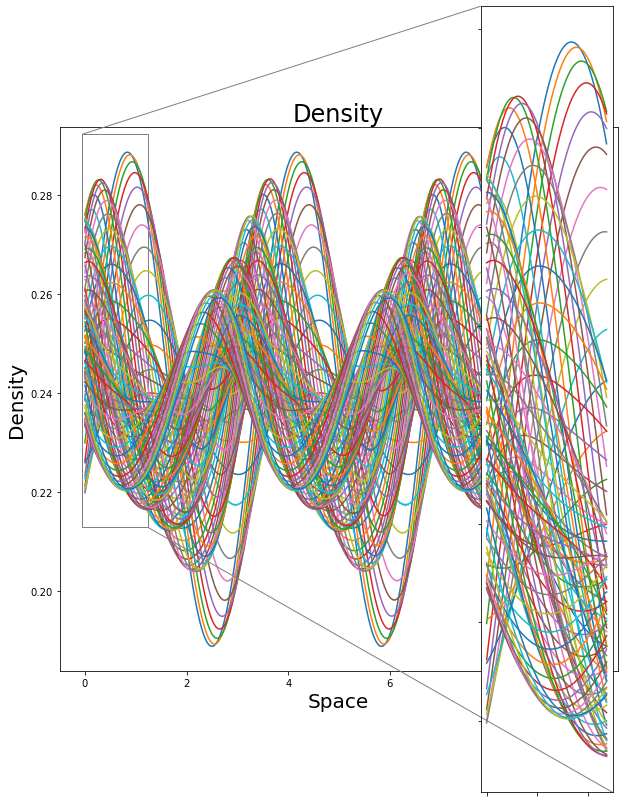

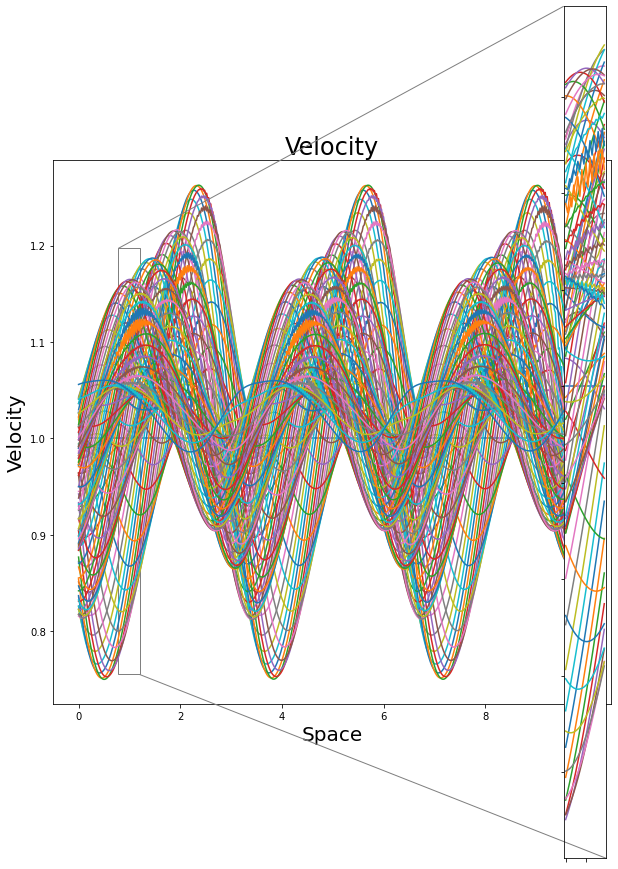

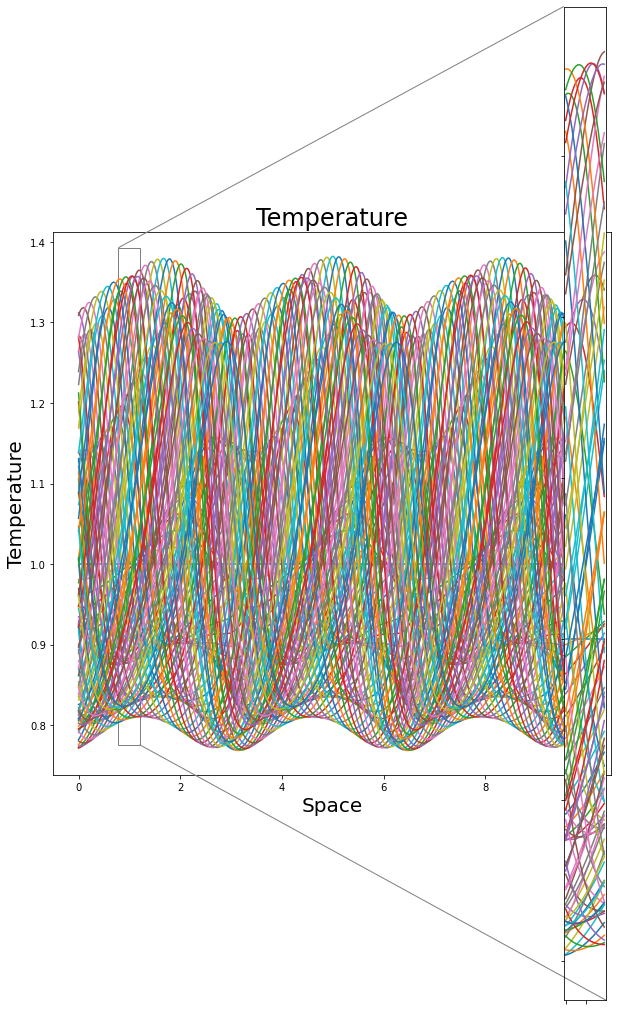

In [15]:
fig, ax = plt.subplots(figsize = single_plot_figsize)
plt.plot(X,ntot[:,num_time_plots])
plt.title("Density", fontsize=24)
plt.xlabel("Space", fontsize=20)
plt.ylabel("Density", fontsize=20)

axins = zoomed_inset_axes(ax, 2, loc=7)
# axins.plot(X[int(Xnum/2 -10):int(Xnum/2 + 10)],ntot[int(Xnum/2 -10):int(Xnum/2 +10),num_time_plots])
axins.plot(X[0:60],ntot[0:60,num_time_plots])
# axins.set_xlim(1, 2)
# axins.set_ylim(1, 2)
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
plt.draw()
plt.show()


fig, ax = plt.subplots(figsize = single_plot_figsize)
plt.plot(X,vtot[:,num_time_plots])
plt.title("Velocity", fontsize=24)
plt.xlabel("Space", fontsize=20)
plt.ylabel("Velocity", fontsize=20)

axins = zoomed_inset_axes(ax, 2, loc=7)
# axins.plot(X[int(Xnum/2 -10):int(Xnum/2 + 10)],ntot[int(Xnum/2 -10):int(Xnum/2 +10),num_time_plots])
axins.plot(X[40:60],vtot[40:60,num_time_plots])
# axins.set_xlim(1, 2)
# axins.set_ylim(1, 2)
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
plt.draw()
plt.show()


fig, ax = plt.subplots(figsize = single_plot_figsize)
plt.plot(X,etot[:,num_time_plots])
plt.title("Temperature", fontsize=24)
plt.xlabel("Space", fontsize=20)
plt.ylabel("Temperature", fontsize=20)

axins = zoomed_inset_axes(ax, 2, loc=7)
# axins.plot(X[int(Xnum/2 -10):int(Xnum/2 + 10)],ntot[int(Xnum/2 -10):int(Xnum/2 +10),num_time_plots])
axins.plot(X[40:60],etot[40:60,num_time_plots])
# axins.set_xlim(1, 2)
# axins.set_ylim(1, 2)
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
plt.draw()
plt.show()

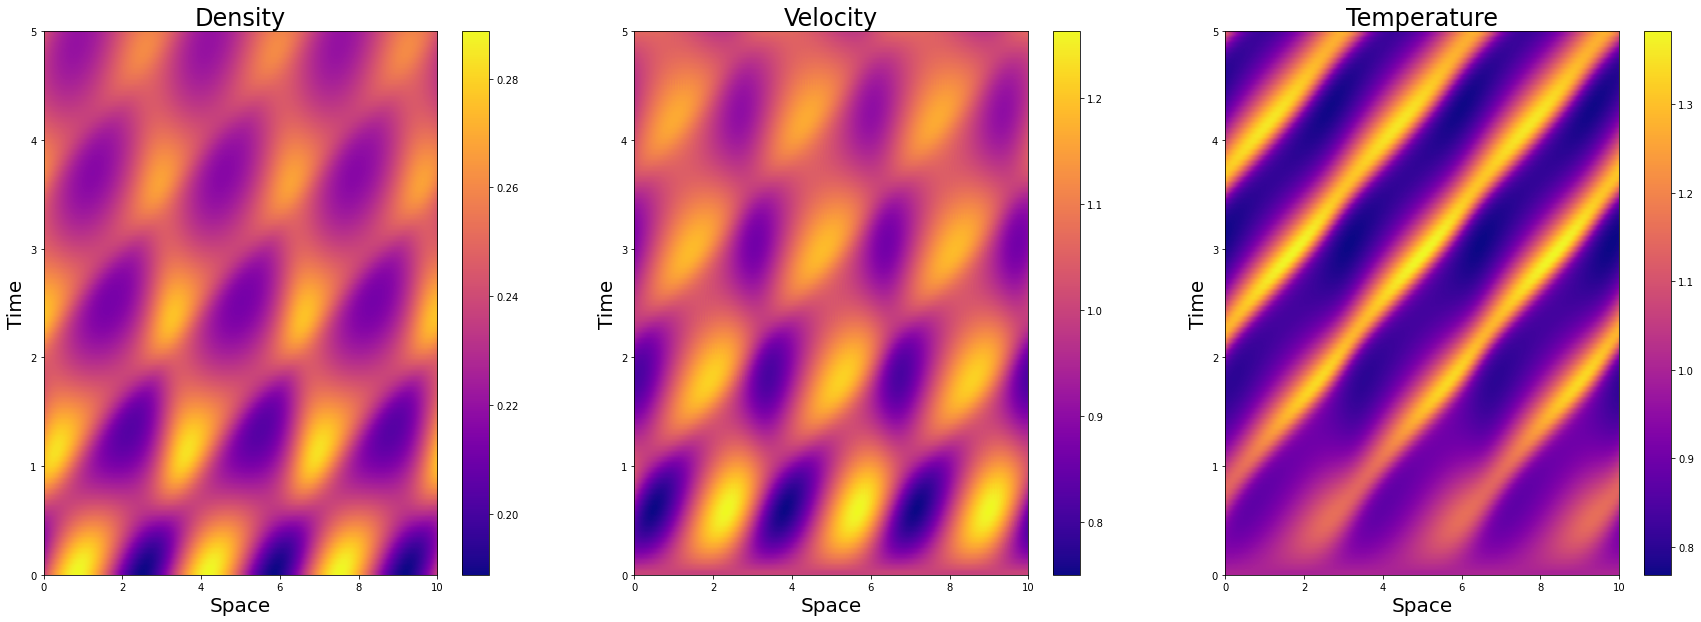

In [16]:
# Colormaps
space_time_domain = [0, Xlngth, 0, Tlngth]

fig, ax = plt.subplots(1,3, figsize=subplot_figsize)
# fig, ax = plt.subplots(figsize = single_plot_figsize)
flip_ntot = np.flip(ntot.T, axis = 0)
n_plt = plt.imshow(flip_ntot, extent=space_time_domain, aspect='auto', cmap='plasma')
ax[0].imshow(flip_ntot, extent=space_time_domain, aspect='auto', cmap='plasma')
ax[0].set_title("Density", fontsize=24)
ax[0].set_xlabel("Space", fontsize=20)
ax[0].set_ylabel("Time", fontsize=20)

# fig, ax = plt.subplots(figsize = single_plot_figsize)
flip_vtot = np.flip(vtot.T, axis = 0)
# plt.imshow(flip_vtot, extent=space_time_domain, aspect='auto', cmap='plasma')
v_plt = ax[1].imshow(flip_vtot, extent=space_time_domain, aspect='auto', cmap='plasma')
ax[1].set_title("Velocity", fontsize=24)
ax[1].set_xlabel("Space", fontsize=20)
ax[1].set_ylabel("Time", fontsize=20)

# fig, ax = plt.subplots(figsize = single_plot_figsize)
flip_etot = np.flip(etot.T, axis = 0)
# plt.imshow(flip_etot, extent=space_time_domain, aspect='auto', cmap='plasma')
e_plt = ax[2].imshow(flip_etot, extent=space_time_domain, aspect='auto', cmap='plasma')
plt.title("Temperature", fontsize=24)
plt.xlabel("Space", fontsize=20)
plt.ylabel("Time", fontsize=20)

fig.colorbar(n_plt, ax=ax[0])
fig.colorbar(v_plt, ax=ax[1])
fig.colorbar(e_plt, ax=ax[2])

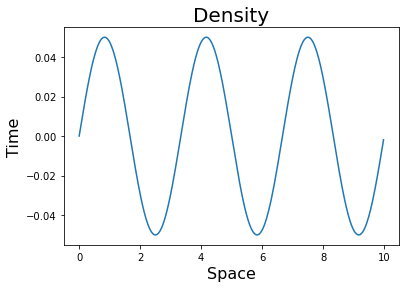

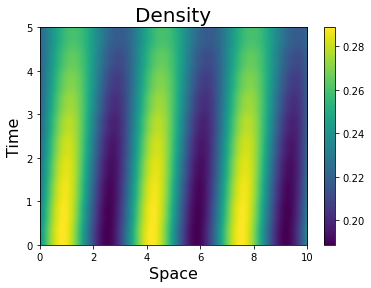

In [17]:
# Plot Initial Condition
plt.plot(X, ntot[:,0]-nmean)
plt.title("Density", fontsize=20)
plt.xlabel("Space", fontsize=16)
plt.ylabel("Time", fontsize=16)

plt.show()

plt.imshow(flip_ntot[-10:], extent=space_time_domain, aspect='auto')
plt.title("Density", fontsize=20)
plt.xlabel("Space", fontsize=16)
plt.ylabel("Time", fontsize=16)

plt.colorbar()

Text(0, 0.5, 'Density')

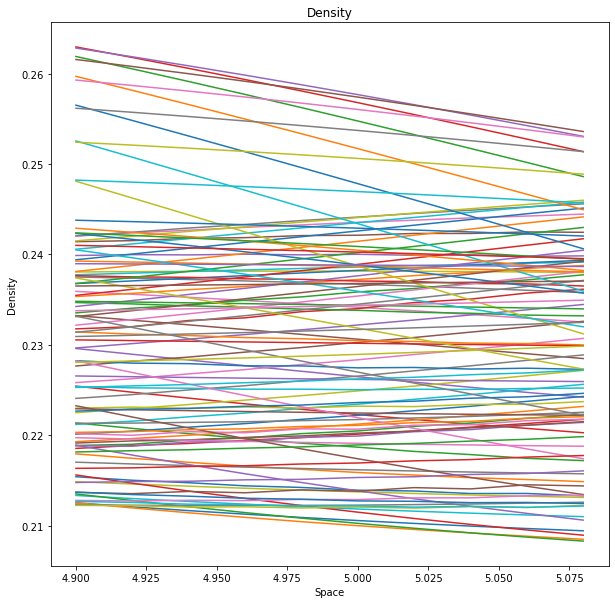

In [18]:
# Plot Boundary Condition
midpoint = int(Xnum/2)
bandwidth = 5

ntot_shift = half_domain_shift(ntot)[midpoint-bandwidth:midpoint+bandwidth]
vtot_shift = half_domain_shift(vtot)[midpoint-bandwidth:midpoint+bandwidth]
X_shift = X[midpoint-bandwidth:midpoint+bandwidth]

fig, ax = plt.subplots(figsize = single_plot_figsize)
plt.plot(X_shift, ntot_shift[0:20])
plt.title("Density")
plt.xlabel("Space")
plt.ylabel("Density")

In [19]:
# def fft(arr):
#     shift_arr = np.fft.ifftshift(arr)
#     shift_fft = np.fft.fft2(shift_arr)
#     fft = np.fft.fftshift(shift_arr)
#     return fft

def fft(arr):
    return np.fft.fftshift(np.fft.fft2(arr))

def fold_average_along_axis(arr, axis=0):
    """
    Fold and average an ndarray along the specified axis.

    Parameters:
        array (numpy.ndarray): Input ndarray.
        axis (int, optional): Axis along which to fold and average (default is 0 for rows).

    Returns:
        numpy.ndarray: Folded and averaged result.
    """
    shape = list(arr.shape)
    shape[axis] = (shape[axis] + 1) // 2  # Calculate the size after folding

    left = arr.take(indices=range(0,shape[axis]), axis=axis)
    right = arr.take(indices=range(-shape[axis],0), axis=axis)
    
    fold_right = np.flip(right, axis=axis)
    folded_avg = (left+fold_right)/2
    return folded_avg

In [20]:
# Create frequency domains for spatial and temporal dimensions
kx = np.fft.fftfreq(Xnum, dx)
kt = np.fft.fftfreq(snaps + 1, Tlngth / snaps)

kx_shifted = np.fft.fftshift(kx)
kt_shifted = np.fft.fftshift(kt)

# Compute the 2D FFT of ntot and shift
ntot_fft_shifted = np.fft.fftshift(np.fft.fft2(ntot-np.mean(nmean)))

# Compute non-negative indices for space and time
nn_indices_x = kx_shifted >= 0
nn_indices_t = kt_shifted >= 0

print(ntot.shape)
print(ntot_fft_shifted.shape)
print(nn_indices_t.shape)

# Extract non-negative frequencies part
nn_ntot_fft = ntot_fft_shifted[nn_indices_x][:, nn_indices_t[:-1]]
nnkx = kx_shifted[nn_indices_x]
nnkt = kt_shifted[nn_indices_t]
pkx = nnkx[nnkx>0]
pkt = nnkt[nnkt>0]


# Compute the magnitude squared to get power spectral density
power_spectral_density = np.abs(nn_ntot_fft)**2

# Normalize the power spectral density
psd_normalized = power_spectral_density / np.max(power_spectral_density)

# Plot the numerical dispersion relations as a colormap
extent = [nnkx.min(), nnkx.max(), nnkt.min(), nnkt.max()]
plt.imshow(np.log(psd_normalized + 1e-10), aspect='auto', extent=extent, origin='lower', cmap='plasma')

### Theoretical Dispersion Relations ###
# Assuming Ideal Gas - No phi nor excess correlations
acoustic_wave_freq = np.mean(etot)
disp_rel_ideal = nnkx * np.sqrt(acoustic_wave_freq)

# Assuming Electrostatic Potential - Include Poisson but no excess correlations
mean_field_correction_freq = 4 * np.pi * Gamma * nmean / pkx**2
disp_rel_phi = np.zeros_like(pkx)
disp_rel_phi[0] = np.sqrt(4 * np.pi * Gamma * nmean)
disp_rel_phi[1:] = (pkx * np.sqrt(acoustic_wave_freq + mean_field_correction_freq))[1:]

# Plotting the theoretical dispersion relations
plt.plot(nnkx, disp_rel_ideal, label='Ideal Gas', linewidth=2)
plt.plot(pkx, disp_rel_phi, label='Electrostatic Potential', linewidth=2)
# plt.plot(kx, disp_rel_cor, label='Correlations', color='blue', linewidth=2)

plt.xlabel('Spatial Frequency (kx)')
plt.ylabel('Temporal Frequency (ω)')
plt.title('Numerical and Theoretical Dispersion Relations')
plt.colorbar(label='Normalized PSD')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.ylim(nnkt.min(), nnkt.max())
plt.show()

(500, 101)
(500, 101)
(101,)


IndexError: boolean index did not match indexed array along dimension 1; dimension is 101 but corresponding boolean dimension is 100

In [ ]:
# kx = np.fft.fftfreq(Xnum,dx)
# kt = np.fft.fftfreq(snaps+1,Tlngth/snaps)
# kx = np.fft.fftshift(kx)
# kt = np.fft.fftshift(kt)

# kx_mesh, kt_mesh = np.meshgrid(kx, kt)

# wavelength = 5
# grating1 = 3*np.sin(2 * np.pi * X_freq_mesh / wavelength)
# grating2 = 2*np.sin(2 * np.pi * T_freq_mesh / wavelength)
# grating3 = np.sin(2 * np.pi * (X_freq_mesh*np.cos(np.pi/5)+T_freq_mesh*np.cos(np.pi/5)) / wavelength)

# amplitudes = 0.5, 0.25, 1, 0.75, 1
# wavelengths = 200, 100, 250, 300, 60
# angles = 0, np.pi / 4, np.pi / 9, np.pi / 2, np.pi / 12
# grating4 = np.zeros_like(grating3)
# for amp, w_len, angle in zip(amplitudes, wavelengths, angles):
#     grating4 += amp * np.sin(
#         2*np.pi*(X_freq_mesh*np.cos(angle) + T_freq_mesh*np.sin(angle)) / w_len
#     )

# fig, ax = plt.subplots(1,4, figsize=(120,30))
# plt.set_cmap("gray")
# ax[0].imshow(grating1, aspect='auto')
# ax[1].imshow(grating2, aspect='auto')
# ax[2].imshow(grating3, aspect='auto')
# ax[3].imshow(grating4, aspect='auto')

# ft1 = np.fft.ifftshift(grating1)
# ft1 = np.fft.fft2(ft1)
# ft1 = np.fft.fftshift(ft1)

# ft2 = np.fft.ifftshift(grating2)
# ft2 = np.fft.fft2(ft2)
# ft2 = np.fft.fftshift(ft2)

# ft3 = np.fft.ifftshift(grating3)
# ft3 = np.fft.fft2(ft3)
# ft3 = np.fft.fftshift(ft3)

# ft4 = np.fft.ifftshift(grating4)
# ft4 = np.fft.fft2(ft4)
# ft4 = np.fft.fftshift(ft4)

# plt.show()

# fig, ax = plt.subplots(1,4, figsize=(120,30))
# ax[0].imshow(np.abs(ft1), aspect='auto')
# ax[1].imshow(np.abs(ft2), aspect='auto')
# ax[2].imshow(np.abs(ft3), aspect='auto')
# ax[3].imshow(np.abs(ft4), aspect='auto')

# fft1 = fft(grating1)
# fft2 = fft(grating2)
# fft3 = fft(grating3)
# fft4 = fft(grating4)

# plt.show()

# fig, ax = plt.subplots(1,4, figsize=(120,30))
# ax[0].imshow(np.abs(ft1), aspect='auto')
# ax[1].imshow(np.abs(ft2), aspect='auto')
# ax[2].imshow(np.abs(ft3), aspect='auto')
# ax[3].imshow(np.abs(ft4), aspect='auto')

# plt.show()

In [ ]:
kx = np.fft.fftfreq(Xnum,dx)
kt = np.fft.fftfreq(snaps+1,Tlngth/snaps)

kx = np.fft.fftshift(kx)
kt = np.fft.fftshift(kt)

nnkx = kx[kx>=0]
nnkt = kt[kt>=0]

pkx = kx[kx>0]
pkt = kt[kt>0]

###################################
# Theoretical Dispersion Relation #
###################################

### FINISHED ###

disp_rel_ideal = np.zeros_like(nnkx)
disp_rel_phi = np.zeros_like(nnkx)
disp_rel_cor = np.zeros_like(nnkx)

# Assuming Ideal Gas - No phi nor excess correlations
acoustic_wave_freq = np.mean(etot)
disp_rel_ideal = nnkx*np.sqrt(acoustic_wave_freq)

# Assuming Electrostatic Potential - Include Poisson but no excess correlations
mean_field_correction_freq = 4*np.pi*Gamma*nmean / pkx**2
disp_rel_phi[0] = np.sqrt(4*np.pi*Gamma*nmean)
disp_rel_phi[1:] = pkx*np.sqrt(acoustic_wave_freq + mean_field_correction_freq)

# Assuming Correlations - Includes Poisson and excess correlations
# cfft = None # TODO: ADD cfft = fft(correlations)
# corr_freq = acoustic_wave_freq*(1-nmean*cfft)
# disp_rel_cor = kx*np.sqrt(corr_freq + mean_field_correction_freq)

# Plotting
fig, ax = plt.subplots(1,1)
plt.plot(nnkx, disp_rel_ideal, label="Ideal")
plt.plot(nnkx, disp_rel_phi, label="Mean Field")
# plt.plot(X_freq, disp_rel_corr(X_freq), label="Mean Field with Excess")

### FINISHED ###

#################################
# Numerical Dispersion Relation #
#################################
print("T", Snap.shape)
print("X", X.shape)

print("kt", kt.shape)
print("kx", kx.shape)

# Test Case
k1 = 2.0 * np.pi
v1 = 1.0
k2 = 3.0 * np.pi
v2 = 1.5

Snap_mesh, X_mesh = np.meshgrid(Snap, X)
kt_mesh, kx_mesh = np.meshgrid(kt, kx)

print("T_mesh", Snap_mesh.shape)
print("X_mesh", X_mesh.shape)

print("kt_mesh", kt_mesh.shape)
print("kx_mesh", kx_mesh.shape)

# Define the spatiotemporal signal with the given nonlinear coupling
# ntot = (np.exp(-Snap_mesh) * np.sin(k1 * X_mesh - v1 * Snap_mesh) +
#      np.exp(-Snap_mesh/2) * np.sin(k2 * X_mesh - v2 * Snap_mesh) +
#      np.exp(-Snap_mesh) * np.sin(k1 * X_mesh - v1 * Snap_mesh) * np.sin(k1 * X_mesh - v1 * Snap_mesh))

ntot = sol.y[:Xnum].reshape(Xnum, -1)

print("ntot", ntot.shape)

centered_ntot = ntot - np.mean(ntot)
nfft = fft(centered_ntot)
nfft1 = fft(np.fft.ifftshift(centered_ntot))

print("nfft", nfft.shape)

print(nfft == nfft1)

structure_factor = np.log(np.abs(nfft)**2)
# structure_factor = np.abs(nfft)**2
structure_factor1 = np.log(np.abs(nfft1)**2)
# structure_factor1 = np.abs(nfft1)**2

# structure_factor[structure_factor.shape[0] // 2,:] = (structure_factor[structure_factor.shape[0] // 2 + 1,:] + structure_factor[structure_factor.shape[0] // 2 - 1,:])/2

structure_factor = np.flip(structure_factor, axis=0)
structure_factor1 = np.flip(structure_factor1, axis=0)

fold_sf = fold_average_along_axis(structure_factor, axis=0)
fold_sf = fold_average_along_axis(fold_sf, axis=1)
fold_sf = np.flip(fold_sf, axis=0)
fold_sf = np.flip(fold_sf, axis=1)

fold_sf1 = fold_average_along_axis(structure_factor1, axis=0)
fold_sf1 = fold_average_along_axis(fold_sf1, axis=1)
fold_sf1 = np.flip(fold_sf1, axis=0)
fold_sf1 = np.flip(fold_sf1, axis=1)

print(fold_sf.shape)

# Plotting
# plt.figure(figsize=(8, 6))
# plt.pcolormesh(nnkx, nnkt, fold_sf.T, shading='auto', cmap='plasma')
# plt.colorbar(label=r'$|n(k,\omega)|^2$')
# plt.xlabel('Spatial Frequency (k)')
# plt.ylabel('Temporal Frequency (ω)')
# plt.title(r'Magnitude Squared of Fourier Transform: $\log(|n(k,\omega)|^2)$')
# plt.show()

# plt.figure(figsize=(8, 6))
# plt.pcolormesh(nnkx, nnkt, fold_sf1.T, shading='auto', cmap='plasma')
# plt.colorbar(label=r'$|n(k,\omega)|^2$')
# plt.xlabel('Spatial Frequency (k)')
# plt.ylabel('Temporal Frequency (ω)')
# plt.title(r'Magnitude Squared of Fourier Transform: $\log(|n(k,\omega)|^2)$')
# plt.show()

# plt.figure(figsize=(8, 6))
# plt.pcolormesh(nnkx, nnkt, (np.exp(fold_sf1)-np.exp(fold_sf)).T, shading='auto', cmap='plasma')
# plt.colorbar(label=r'$|n(k,\omega)|^2$')
# plt.xlabel('Spatial Frequency (k)')
# plt.ylabel('Temporal Frequency (ω)')
# plt.title(r'Difference with ifftshift()')
# plt.show()

plt.figure(figsize=(8, 6))
plt.pcolormesh(kx, kt, structure_factor.T, shading='auto', cmap='plasma')
plt.colorbar(label=r'$|n(k,\omega)|^2$')
plt.xlabel('Spatial Frequency (k)')
plt.ylabel('Temporal Frequency (ω)')
plt.title(r'Magnitude Squared of Fourier Transform: $\log(|n(k,\omega)|^2)$')
plt.show()

plt.figure(figsize=(8, 6))
plt.pcolormesh(kx, kt, structure_factor1.T, shading='auto', cmap='plasma')
plt.colorbar(label=r'$|n(k,\omega)|^2$')
plt.xlabel('Spatial Frequency (k)')
plt.ylabel('Temporal Frequency (ω)')
plt.title(r'Magnitude Squared of Fourier Transform: $\log(|n(k,\omega)|^2)$')
plt.show()

plt.figure(figsize=(8, 6))
plt.pcolormesh(kx, kt, (np.exp(structure_factor1)-np.exp(structure_factor)).T, shading='auto', cmap='plasma')
plt.colorbar(label=r'$|n(k,\omega)|^2$')
plt.xlabel('Spatial Frequency (k)')
plt.ylabel('Temporal Frequency (ω)')
plt.title(r'Difference with ifftshift()')
plt.show()

print(np.sqrt(4*np.pi*Gamma*nmean))

In [ ]:
# Define spatial and temporal parameters
# x_max = 10.0  # Maximum spatial value
# t_max = 10.0  # Maximum temporal value
# dx = 0.02  # Spatial step
# dt = 0.1  # Temporal step
# x = np.arange(0, x_max, dx)
# t = np.arange(0, t_max, dt)
# X, T = np.meshgrid(x, t)

# # Define wave parameters for the two waves
# k1 = 2.0 * np.pi
# v1 = 1.0
# k2 = 3.0 * np.pi
# v2 = 1.5

# # Define the spatiotemporal signal with the given nonlinear coupling
# n = (np.exp(-T) * np.sin(k1 * X - v1 * T) +
#      np.exp(-T/2) * np.sin(k2 * X - v2 * T) +
#      np.exp(-T) * np.sin(k1 * X - v1 * T) * np.sin(k1 * X - v1 * T))

# # Compute the 2D Fourier transform
# n_k_omega = np.fft.fftshift(np.fft.fft2(n))

# # Compute the magnitude squared of the Fourier-transformed signal
# magnitude_squared = np.abs(n_k_omega)**2

# # Create a frequency grid for plotting
# freq_x = np.fft.fftshift(np.fft.fftfreq(n.shape[1], dx))
# freq_t = np.fft.fftshift(np.fft.fftfreq(n.shape[0], dt))

# # Plotting
# plt.figure(figsize=(8, 6))
# plt.pcolormesh(freq_x, freq_t, magnitude_squared, shading='auto', cmap='plasma')
# plt.colorbar(label=r'$|n(k,\omega)|^2$')
# plt.xlabel('Spatial Frequency (k)')
# plt.ylabel('Temporal Frequency (ω)')
# plt.title(r'Magnitude Squared of Fourier Transform: $|n(k,\omega)|^2$')
# plt.show()

# print(t)
# print(Snap[:-1])

# print(t==Snap[:-1])
# # print(n_k_omega == nfft)

# print(n_k_omega.shape)
# print(nfft.shape)

In [ ]:
# # Theoretical Dispersion Relation
# min_dt = np.min(np.diff(sol.t))
# T_freq_min = 2*np.pi/Tlngth
# T_freq_max = np.pi/min_dt
# X_freq_min = 2*np.pi/Xlngth
# X_freq_max = np.pi/(2*dx)

# print(T_freq_min)
# print(T_freq_max)
# print(X_freq_min)
# print(X_freq_max)

# X_freq = np.linspace(X_freq_min, X_freq_max, num=Xnum)
# T_freq = np.linspace(T_freq_min, T_freq_max, num=snaps+1)

# space_time_freq_domain = [X_freq_min, X_freq_max, T_freq_min, T_freq_max]

# # Assuming Ideal Gas - No phi nor excess correlations
# acoustic_wave_freq = np.mean(etot)
# disp_rel_ideal = X_freq*np.sqrt(acoustic_wave_freq)

# # Assuming Electrostatic Potential - Include Poisson but no excess correlations
# mean_field_correction_freq = 4*np.pi*Gamma*nmean / X_freq**2
# disp_rel_phi = X_freq*np.sqrt(acoustic_wave_freq + mean_field_correction_freq)

# # Assuming Correlations - Includes Poisson and excess correlations
# # cfft = None # TODO: ADD cfft = fft(correlations)
# # corr_freq = acoustic_wave_freq*(1-nmean*cfft)
# # disp_rel_phi = X_freq*np.sqrt(corr_freq + mean_field_correction_freq)

# # Plotting
# fig, ax = plt.subplots(1,1)
# plt.plot(X_freq, disp_rel_ideal, label="Ideal")
# plt.plot(X_freq, disp_rel_phi, label="Mean Field")
# # plt.plot(X_freq, disp_rel_corr(X_freq), label="Mean Field with Excess")

# # Numerical Dispersion Relation
# centered_ntot = ntot - np.mean(ntot)
# nfft = fft(centered_ntot)

# folded_nfft = fold_average_along_axis(nfft, axis=0)
# folded_nfft = fold_average_along_axis(folded_nfft, axis=1)

# # structure_factor = np.abs(folded_nfft)**2
# structure_factor = np.abs(nfft)**2  # For checking folding
# # structure_factor = np.flip(structure_factor,axis=1).T
# # structure_factor = np.flip(structure_factor,axis=0)

# # Plotting
# # nfft_1 = np.abs(np.log(folded_nfft)).T
# # nfft_2 = np.fft.fftshift(np.abs(np.log(folded_nfft)).T)

# X_freq_mesh, T_freq_mesh = np.meshgrid(X_freq, T_freq)

# strcr_fctr_plt = ax.pcolormesh(X_freq_mesh, T_freq_mesh, structure_factor.T,
#                               shading = 'auto',
#                               # norm = mpl.colors.LogNorm(vmin = 1e-9, vmax = 1e2),
#                               # cmap='nipy_spectral',
#                               cmap='plasma')

# ax.set(xlabel = "Spatial Frequency (k)",
#       ylabel = r"Dispersion ($\omega$)")

# # plt.imshow(np.log(structure_factor), extent=space_time_freq_domain, aspect='auto', cmap='plasma')
# # plt.imshow(nfft_1, extent=space_time_freq_domain, aspect='auto', cmap='plasma')
# ax.set_title("Fourier Transform of Density")
# # plt.xlabel("Spatial Frequency (k)")
# # plt.ylabel("Dispersion (omega)")
# plt.colorbar(strcr_fctr_plt)
# plt.legend()

In [ ]:
def analyze_2D_data_with_DMD(data, x_values, t_values):
    xgrid, tgrid = np.meshgrid(x_values, t_values, indexing='ij')
    
    # Instantiate the DMD class and fit the data
    dmd = DMD(svd_rank=2)
    dmd.fit(data.T)

    # Print the distance of each eigenvalue from the unit circle
    for eig in dmd.eigs:
        distance = np.abs(np.abs(eig) - 1)
        print(f"Eigenvalue {eig}: distance from unit circle {distance}")

    # Plot the eigenvalues
    plot_eigs(dmd, show_axes=True, show_unit_circle=True)
    
    # Plot the modes
    plt.figure(figsize=(10, 4))
    for i, mode in enumerate(dmd.modes.T, 1):
        plt.subplot(1, 2, i)
        plt.plot(x_values, mode.real)
        plt.title(f"Mode {i}")
    plt.show()

    # Plot the dynamics
    plt.figure(figsize=(10, 4))
    for i, dynamic in enumerate(dmd.dynamics, 1):
        plt.subplot(1, 2, i)
        plt.plot(t_values, dynamic.real)
        plt.title(f"Dynamic {i}")
    plt.show()

    # Reconstruct the data and plot the original, reconstructed, and error
    reconstructed_data = dmd.reconstructed_data.T.real
    error = data - reconstructed_data
    
    fig, axs = plt.subplots(1, 3, figsize=(17, 6))
    titles = ["Original Data", "Reconstructed Data", "Absolute Error"]
    datasets = [data, reconstructed_data, np.abs(error)]

    for ax, title, dset in zip(axs, titles, datasets):
        c = ax.pcolormesh(xgrid, tgrid, dset, shading='auto')
        ax.set_title(title)
        fig.colorbar(c, ax=ax)
    plt.show()

# Sample Usage
x_values, t_values = np.linspace(-5, 5, 100), np.linspace(0, 4 * np.pi, 200)
data = np.random.random((100, 200))  # Replace this with your actual data
analyze_2D_data_with_DMD(data, x_values, t_values)

In [ ]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

def plot_morlet_wavelet(data, target_frequencies, fs=snaps/Tlngth, Snap=Snap):
    # Create a figure
    fig, axs = plt.subplots(len(target_frequencies), 1, figsize=(10, 2*len(target_frequencies)))
    
    for i, f_k in enumerate(target_frequencies):
        deltaf = np.min(np.abs(data_freqs - f_k))
        bandwidth = np.sqrt(2 * np.log(2)) * f_k / (np.pi * 0.5 * deltaf)
        center_freq = np.sqrt(2) * bandwidth
        wavelet = f'cmor{center_freq}-{bandwidth}'
        
        # Calculate the continuous wavelet transform
        coeffs, freqs = pywt.cwt(data, scales=np.arange(1, 16), wavelet=wavelet, sampling_period=1/fs)
        
        # Plot the transform
        axs[i].imshow(np.abs(coeffs), extent=[Snap[0], Snap[-1], freqs.min(), freqs.max()], 
                      aspect='auto', cmap='jet', origin='lower')
        axs[i].set_title(f'Morlet Wavelet Transform (Target Frequency: {f_k} Hz)')
        axs[i].set_ylabel('Frequency (Hz)')
        
    axs[-1].set_xlabel('Time (s)')
    plt.tight_layout()
    plt.show()

# Example usage
snaps = 1000
S = np.linspace(0, Tlngth, snaps, endpoint=False)
data_freqs = 2*np.pi*np.array([4, 6, 10])
data = np.sin(data_freqs[0]*S) * (S<.5) + np.sin(data_freqs[2]*S) * (S>=.5) # + np.sin(data_freqs[1]*S)*(S>=.2)*(S<.6) 
target_frequencies = [1,5, 10, 15 ,20]

plt.plot(S,data)


plot_morlet_wavelet(data, target_frequencies, fs=snaps)

In [ ]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

def plot_morlet_wavelet(data, target_frequencies, fs=1.0, deltaf_prime=0.1):
    if data.ndim != 1:
        raise ValueError("Input data must have shape (int,)")
    
    time = np.arange(data.shape[0]) / fs
    fig, axs = plt.subplots(len(target_frequencies), 1, figsize=(10, 2 * len(target_frequencies)), squeeze=False)
    
    for i, f_k in enumerate(target_frequencies):
        # Calculate the nearest frequency to the target frequency
        nearest_frequency = min(target_frequencies, key=lambda x: abs(x - f_k) if x != f_k else float('inf'))
        
        # Calculate the bandwidth
        bandwidth = np.sqrt(2 * np.log(2)) * f_k / (np.pi * abs(f_k - nearest_frequency))
        
        # Calculate the center frequency for the Morlet wavelet
        center_freq = np.sqrt(2 * bandwidth)
        
        # Define the wavelet
        wavelet = f'cmor{center_freq}-{bandwidth}'
        
        # Calculate the scales
        scales = np.linspace(1/f_k, 10/f_k, 100)
        
        # Perform the continuous wavelet transform
        coeffs, freqs = pywt.cwt(data, scales, wavelet, sampling_period=1/fs)
        
        # Plot the wavelet transformation
        im = axs[i, 0].imshow(np.abs(coeffs), extent=[time[0], time[-1], freqs.min(), freqs.max()], aspect='auto', cmap='jet', interpolation='bilinear')
        axs[i, 0].set_ylabel('Frequency (Hz)')
        axs[i, 0].set_title(f'Morlet Wavelet Transform (Target Frequency: {f_k} Hz)')
    
    axs[-1, 0].set_xlabel('Time (s)')
    plt.tight_layout()
    plt.show()

# Example usage
snaps = 1000
S = np.linspace(0, 1, snaps, endpoint=False)
data_freqs = 2*np.pi*np.array([4, 6, 10])
data = np.sin(data_freqs[0]*S) * (S<.5) + np.sin(data_freqs[2]*S) * (S>=.5) # + np.sin(data_freqs[1]*S)*(S>=.2)*(S<.6) 
target_frequencies = [1,2,3,4,5,6,8,10,12]

plt.plot(S,data)


plot_morlet_wavelet(data, target_frequencies, fs=snaps)

In [ ]:
def plot_morlet_wavelet(data, center_frequencies, fs=1.0):
    if data.ndim != 1:
        raise ValueError("Input data must have shape (int,)")

    time = np.arange(data.shape[0]) / fs
    fig, axs = plt.subplots(len(center_frequencies), 1, figsize=(10, 2 * len(center_frequencies)), squeeze=False)
    
    for i, freq in enumerate(center_frequencies):
        scales = np.linspace(1/freq, 10/freq, 100)  # Adjust the range and number of scales as needed
        coeffs, freqs = pywt.cwt(data, scales, 'cmor', sampling_period=1/fs)
        
        if np.isclose(freqs.min(), freqs.max()):
            print(f"Warning: Frequency range is too narrow for center frequency {freq} Hz. Adjusting scales might be necessary.")
            continue

        im = axs[i, 0].imshow(np.abs(coeffs), extent=[time[0], time[-1], freqs.min(), freqs.max()], aspect='auto', cmap='jet', interpolation='bilinear')
        axs[i, 0].set_ylabel('Frequency (Hz)')
        axs[i, 0].set_title(f'Morlet Wavelet Transform (Center Frequency: {freq} Hz)')
    
    axs[-1, 0].set_xlabel('Time (s)')
    plt.tight_layout()
    plt.show()

# Example usage
# Generate some example data
np.random.seed(42)
freqs = [1,3,10,20]
data = np.sin(2*np.pi*30*Snap)*(Snap<snaps/4) + np.sin(2*np.pi*80*Snap)*np.logical_and(Snap>=snaps/4, Snap<=snaps/2) + np.sin(2*np.pi*20*Snap)*(Snap>snaps/2)


plt.plot(Snap, data)
# Define the center frequencies
center_frequencies = [2, 3, 10, 15]

# Plot the Morlet wavelet transform
plot_morlet_wavelet(data, center_frequencies, fs=3)

In [ ]:
# Wavelet Transformation Test
def plot_wavelet(signal, center_freq, bandwidth):
     if data.ndim != 1:
        raise ValueError("Input data must have shape (int,)")
        
    # Create a quad plot for the wavelet transform using different values of ω₀
    fig, axs = plt.subplots(len(center_freq), len(, figsize=(18, 12))
    fig.suptitle(f'Wavelet Transform (Magnitude) of Signal for Different ω₀', fontsize=16)

    widths = np.arange(1, 128)
    
    wavelet = f'cmor{center_freq}-{bandwidth}'
    
    for i, ax in enumerate(axs.flat):        
        # Wavelet transform using Morlet wavelet with specified ω₀
        coefficients = cwt(data, scales, wavelet)
        
        # Convert scales to frequencies
        frequencies = omega_0_values[i] / (4 * np.pi * widths)

        ax.imshow(np.abs(coefficients), aspect='auto', extent=[0, len(signal), frequencies[-1], frequencies[0]], cmap='jet', interpolation='bilinear')
        ax.set_title(f'ω₀ = {omega_0_values[i]}')
        ax.set_xlabel('Time')
        if i % 2 == 0:
            ax.set_ylabel('Frequency (Hz)')
    
    plt.show()

# Example signal
signal = np.sin(2 * np.pi * np.linspace(0, 1, 1000) * 5)  # 5 Hz sine wave
plot_wavelet(signal)
            
plot_wavelet(ntot[0,:])
# plot_wavelet(ntot[int(snaps/4),:])
# plot_wavelet(ntot[int(snaps/2),:])
# plot_wavelet(ntot[int(3*snaps/4),:])

# freqs = np.arange(snaps/10)/50
freqs = [2,5,8,10]
segments = len(freqs)
segment_length = len(X) // segments

signal = np.array([])
for freq in freqs:
    segment = np.sin(2 * np.pi * freq * X[:segment_length])
    signal = np.concatenate((signal, segment))

signal[int(segment_length/3):8*int(segment_length/3)] += np.sin(2 * np.pi * .5*X[int(segment_length/3):8*int(segment_length/3)])

# freqs = np.arange(Xnum)
# signal = np.sin(2* np.pi * freqs)
    
fig = plt.figure()
plt.plot(X, signal)
plt.show()
plot_wavelet(signal)

In [ ]:
# Wavelet Transformation Test

# scales = np.arange(1,Xlngth+1)  # TODO: FIX
M = 15  #
s = 10
w = np.arange(1,16)
wavelet = scipy.signal.morlet2(M, s, w)
print(wavelet)

# scipy.signal.morlet2(M=Length of the wavelet, s=Width parameter of the wavelet, w=Omega0. Default is 5)
scipy.signal.cwt(data: (N,), 
                 wavelet=Wavelet function, which should take 2 arguments. The first argument is the number of points that the returned vector will have (len(wavelet(length,width)) == length). The second is a width parameter, defining the size of the wavelet (e.g. standard deviation of a gaussian). See ricker, which satisfies these requirements., 
                 widths: (M,)=Widths to use for transform, dtype=None, **kwargs) 

wvlt_IC = ntot[0,:]
wvlt_1Q = ntot[int(snaps/4),:]
wvlt_Mid = ntot[int(snaps/2),:]
wvlt_3Q = ntot[int(3*snaps/4),:]
wvlt_End = ntot[-1,:]

# print(ntot.shape)
# print(wvlt_IC.shape)

fig, ax = plt.subplots(2,5, figsize=(50,10))
wvlt_IC_sgnl_plt = ax[0,0].plot(T,wvlt_IC)
wvlt_1Q_sgnl_plt = ax[0,1].plot(T,wvlt_1Q)
wvlt_Mid_sgnl_plt = ax[0,2].plot(T,wvlt_Mid)
wvlt_3Q_sgnl_plt = ax[0,3].plot(T,wvlt_3Q)
wvlt_End_sgnl_plt = ax[0,4].plot(T,wvlt_End)

wavelet_domain = [0, Tlngth, scales.min(), scales.max()]

[wvlt_coef_IC, wvlt_freq_IC] = scipy.signal.cwt(data=wvlt_IC, wavelet=wavelet, widths=w)
wvlt_IC_plt = ax[1,0].imshow(wvlt_coef_IC, extent=wavelet_domain, aspect='auto', cmap='plasma')
ax[1,0].set_ylabel('Frequency')
ax[1,0].set_xlabel('Time')

[wvlt_coef_1Q, wvlt_freq_1Q] =  scipy.signal.cwt(data=wvlt_1Q, wavelet=wavelet, widths=scales)
wvlt_IC_plt = ax[1,1].imshow(wvlt_coef_1Q, extent=wavelet_domain, aspect='auto', cmap='plasma')
ax[1,1].set_ylabel('Frequency')
ax[1,1].set_xlabel('Time')

[wvlt_coef_Mid, wvlt_freq_Mid] = pywt.cwt(data=wvlt_Mid, scales=scales, wavelet=wavelet_name)
wvlt_IC_plt = ax[1,2].imshow(wvlt_coef_Mid, extent=wavelet_domain, aspect='auto', cmap='plasma')
ax[1,2].set_ylabel('Frequency')
ax[1,2].set_xlabel('Time')

[wvlt_coef_3Q, wvlt_freq_3Q] = pywt.cwt(data=wvlt_3Q, scales=scales, wavelet=wavelet_name)
wvlt_IC_plt = ax[1,3].imshow(wvlt_coef_3Q, extent=wavelet_domain, aspect='auto', cmap='plasma')
ax[1,3].set_ylabel('Frequency')
ax[1,3].set_xlabel('Time')

[wvlt_coef_End, wvlt_freq_End] = pywt.cwt(data=wvlt_End, scales=scales, wavelet=wavelet_name)
wvlt_IC_plt = ax[1,4].imshow(wvlt_coef_End, extent=wavelet_domain, aspect='auto', cmap='plasma')
ax[1,4].set_ylabel('Frequency')
ax[1,4].set_xlabel('Time')

for ii in range(5):
    ax[0,ii].set_ylabel('Density')
    ax[0, ii].set_xlabel('Time')
    
for ii in range(5):
    ax[1, ii].set_ylabel('Frequency')
    ax[1, ii].set_xlabel('Time')

In [ ]:
# Wavelet Transformation
wavelet_name = 'morl'
scales = np.arange(1,257)  # TODO: FIX

wvlt_data_IC = ntot[:,0]
wvlt_data_Mid = ntot[:,int(snaps/2)]
wvlt_data_End = ntot[:,-1]

# wvlt_data_IC = ntot[0,:]
# wvlt_data_Mid = ntot[int(Tlngth/2),:]
# wvlt_data_End = ntot[-1,:]

print(wvlt_data_IC.shape)
print(X.shape)

[coefficients_IC, frequencies_IC] = pywt.cwt(data=wvlt_data_IC, scales=scales, wavelet=wavelet_name, sampling_period=1000)
[coefficients_Mid, frequencies_Mid] = pywt.cwt(data=wvlt_data_IC, scales=scales, wavelet=wavelet_name, sampling_period=10)
[coefficients_End, frequencies_End] = pywt.cwt(data=wvlt_data_IC, scales=scales, wavelet=wavelet_name, sampling_period=.1)

wavelet_domain = [0, Xlngth, scales.min(), scales.max()]

fig, ax = plt.subplots(2,3, figsize=subplot_figsize)
wvlt_IC_sgnl_plt = ax[0,0].plot(X,wvlt_data_IC)
wvlt_Mid_sgnl_plt = ax[0,1].plot(X,wvlt_data_Mid)
wvlt_End_sgnl_plt = ax[0,2].plot(X,wvlt_data_End)


wvlt_IC_plt = ax[1,0].imshow(coefficients_IC, extent=wavelet_domain, aspect='auto', cmap='plasma')
ax[1,0].set_ylabel('Frequency')
ax[1,0].set_xlabel('Time')
# ax2 = ax[1,0].twinx()
# ax2.set_ylabel('period [s]')

# strs = [str(round(1 / freq, 3)) for freq in frequencies_IC]
# strs = [str(round(freq)) for freq in frequencies_IC]
# ax2.set_yticks(np.arange(coefficients_IC.shape[0]))
# ax2.set_yticklabels(strs)

wvlt_Mid_plt = ax[1,1].imshow(coefficients_Mid, extent=wavelet_domain, aspect='auto', cmap='plasma')
ax[1,1].set_ylabel('Frequency')
ax[1,1].set_xlabel('Time')
# ax2 = ax[1,1].twinx()
# ax2.set_ylabel('period [s]')

# strs = [str(round(1 / freq, 3)) for freq in frequencies_Mid]
# strs = [str(round(freq)) for freq in frequencies_Mid]
# ax2.set_yticks(np.arange(coefficients_Mid.shape[0]))
# ax2.set_yticklabels(strs)

wvlt_End_plt = ax[1,2].imshow(coefficients_End, extent=wavelet_domain, aspect='auto', cmap='plasma')
ax[1,2].set_ylabel('Frequency')
ax[1,2].set_xlabel('Time')
# ax2 = ax[1,2].twinx()
# ax2.set_ylabel('period [s]')

# strs = [str(round(1 / freq, 3)) for freq in frequencies_End]
# strs = [str(round(freq)) for freq in frequencies_End]
# ax2.set_yticks(np.arange(coefficients_End.shape[0]))
# ax2.set_yticklabels(strs)

fig.colorbar(wvlt_IC_plt, ax=ax[1,0])
fig.colorbar(wvlt_Mid_plt, ax=ax[1,1])
fig.colorbar(wvlt_End_plt, ax=ax[1,2])

plt.show()

In [ ]:
%matplotlib inline

wvlt_coeffs = []
wvlt_freqs = []

for ii in range(len(T)):
    ntot_slice = ntot[:, ii]
    [wvlt_coeff, wvlt_freq] = pywt.cwt(ntot_slice, scales, wavelet_name, min_dt)
    wvlt_coeffs.append(wvlt_coeff)
    wvlt_freqs.append(wvlt_freq)

def change_plot(frame_number, data, plot):
#     frame_number %= int(len(data))
    plot[0].remove()
    plot[0] = ax.imshow(data[frame_number], cmap="plasma", extent=wavelet_domain, aspect='auto')
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Time')
    
    ax2 = ax.twinx()
    ax2.set_ylabel('Period')
#     # TODO: Fix Period Labeling
#     strs = [str(round(1 / freq, 3)) for freq in frequencies_End]
#     strs = [str(round(freq)) for freq in frequencies_End]
#     ax2.set_yticks(np.arange(coefficients.shape[0]))
#     ax2.set_yticklabels(strs)

wavelet_domain = [0, Xlngth, np.max(scales), np.min(scales)]
    
fig = plt.figure(figsize=single_plot_figsize)
ax = fig.add_subplot(111)
ax.set_ylabel('Frequency')
ax.set_xlabel('Time')
ax2 = ax.twinx()
ax2.set_ylabel('Period')

# Initialize the first frame
plot = [ax.imshow(wvlt_coeffs[0], cmap='plasma', extent=wavelet_domain, aspect='auto')]

cbar = plt.colorbar(plot[0], ax=ax)

# Animate Wavelet Transformation
ani = FuncAnimation(fig, change_plot, frames=range(len(T)), fargs=(wvlt_coeffs, plot), interval=10, save_count=T)

# plt.tight_layout()
# plt.show()
HTML(ani.to_jshtml())
# ani.save(filename=r"C:\Users\chris\OneDrive\Desktop\anim.gif", writer='pillow')

In [ ]:
# Forecasting



In [ ]:
# Var(Number)



In [ ]:
# Kernel DMD - Nonlinear DMD



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def func(x,y):
    
    return xx*yy**4 + xx**4*yy * np.sin(xx)*yy

x = np.linspace(0,11,100)
y = np.linspace(0,11,100)

xx,yy = np.meshgrid(x,y)
zz = func(xx,yy)

plt.figure(figsize=(8,5))
plt.contourf(xx,yy,func(xx,yy),levels=100)

plt.figure(figsize=(8,8))
plt.imshow(zz,origin='lower',interpolation='bicubic')

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(xx,yy,zz)

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from pydmd import DMD
from pydmd.plotter import plot_eigs

def data_DMD(data, rank):    
    # Instantiate the DMD class and fit the data
    dmd = DMD(svd_rank=rank)
    fit = dmd.fit(data)
    return fit
    
def plot_DMD_eigs(dmd):
    # Print the distance of each eigenvalue from the unit circle
    for eig in dmd.eigs:
        distance = np.abs(np.abs(eig) - 1)
        print(f"Eigenvalue {eig}: distance from unit circle {distance}")

    # Plot the eigenvalues
    plot_eigs(dmd, show_axes=True, show_unit_circle=True)
    
def plot_DMD_modes(dmd, rank, x=X):
    # Plot the modes
    plt.figure(figsize=(5*rank, 10))
    for i, mode in enumerate(dmd.modes.T, 1):
        plt.subplot(1, rank, i)
        plt.plot(x, mode.real)
        plt.title(f"Mode {i}")
    plt.show()

def plot_DMD_dynamics(dmd, rank, t=Snap):
    # Plot the dynamics
    plt.figure(figsize=(5*rank, 10))
    for i, dynamic in enumerate(dmd.dynamics, 1):
        plt.subplot(1, rank, i)
        plt.plot(t, dynamic.real)
        plt.title(f"Dynamic {i}")
    plt.show()

def reconstruct_DMD(data, dmd, x=X, t=Snap):
    xgrid, tgrid = np.meshgrid(x, Snap, indexing='ij')
    
    # Reconstruct the data and plot the original, reconstructed, and error
    reconstructed_data = dmd.reconstructed_data.real
    error = data - reconstructed_data
    
    fig, axs = plt.subplots(1, 3, figsize=(17, 6))
    titles = ["Original Data", "Reconstructed Data", "Absolute Error"]
    datasets = [data, reconstructed_data, np.abs(error)]

    for ax, title, dset in zip(axs, titles, datasets):
        # c = ax.pcolormesh(xgrid, tgrid, dset.T, shading='auto')
        c = ax.imshow(dset, aspect = 'auto')
        ax.set_title(title)
        fig.colorbar(c, ax=ax)
    plt.show()
    
    print("Frobenius Norm Error: ", np.sqrt(np.sum((data-reconstructed_data)**2)))

In [127]:
data_dmd.shape

(1000, 96)

(1000, 101)


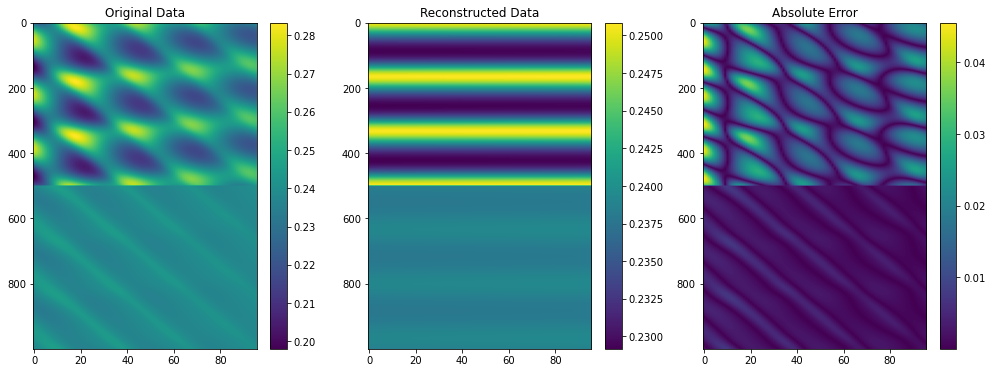

Frobenius Norm Error:  3.1434498847805563


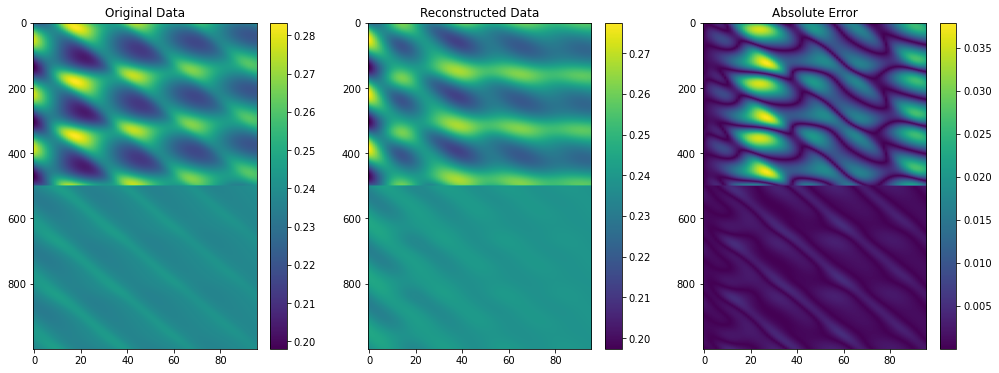

Frobenius Norm Error:  2.9310754561751535


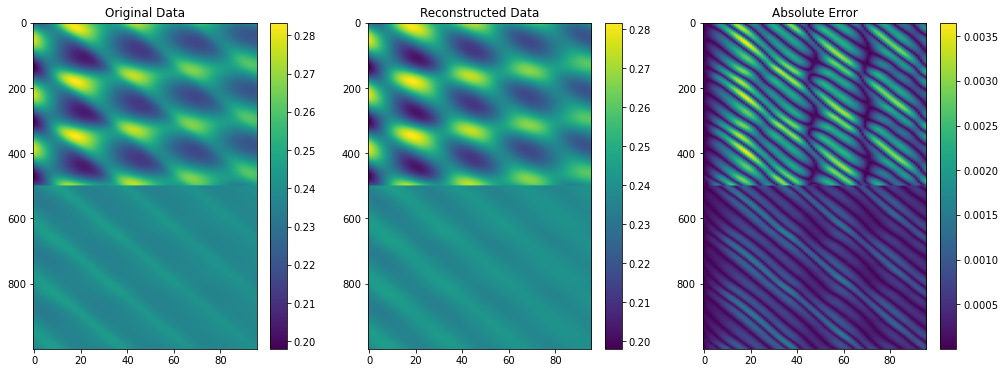

Frobenius Norm Error:  0.35111104087327466


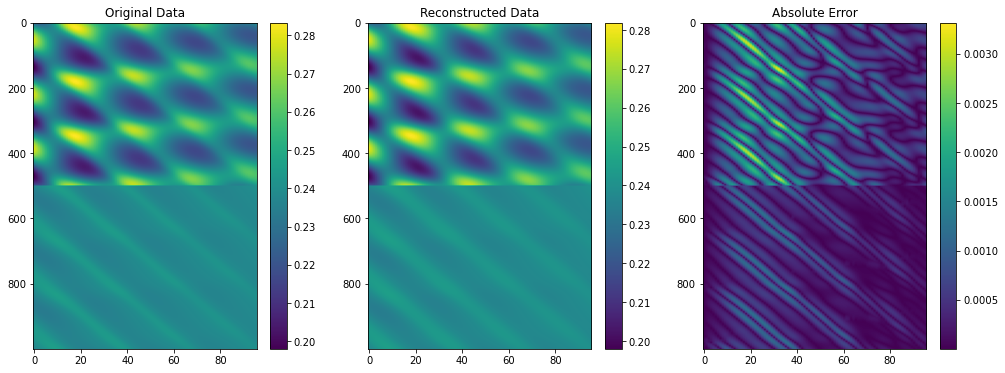

Frobenius Norm Error:  0.22297041335366474


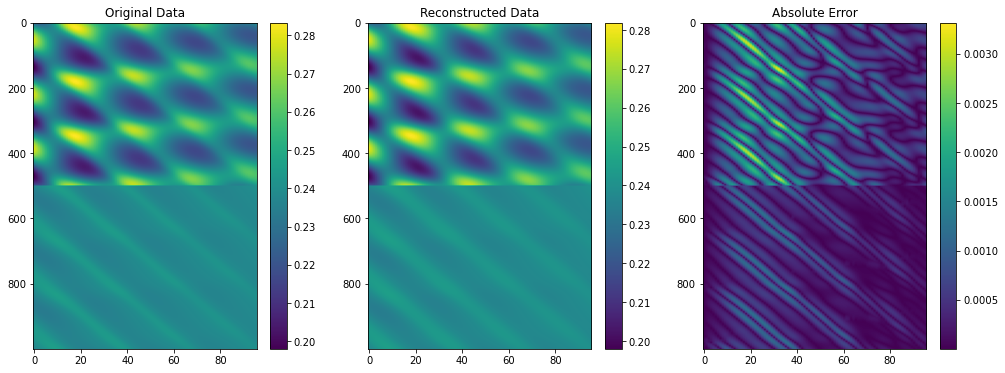

Frobenius Norm Error:  0.22297041335366474


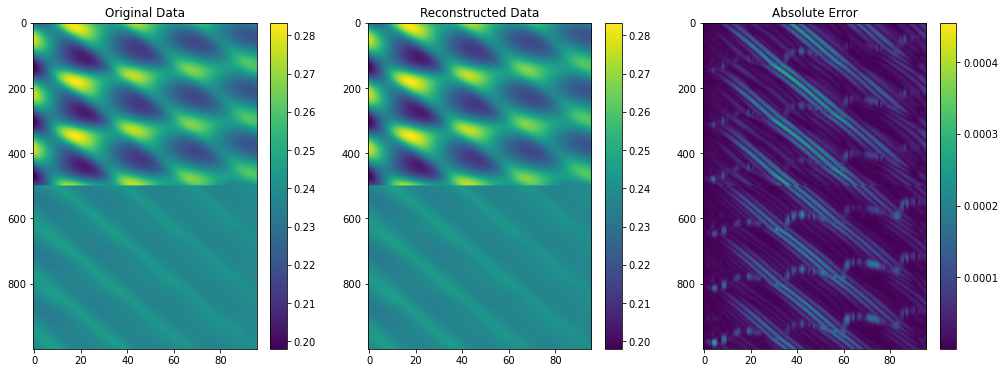

Frobenius Norm Error:  0.019447135330283184


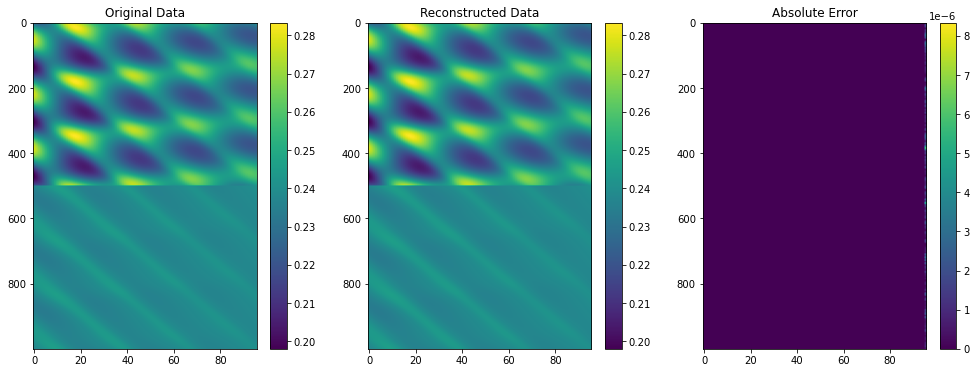

Frobenius Norm Error:  5.13919384489724e-05


In [130]:
ddt_ntot = (ntot - np.roll(ntot, 1, axis = 1))#/(Tlngth/snaps)
ddt_ntot = (ntot - np.roll(ntot, 1, axis = 1)) + nmean
new_data = np.vstack((ntot, ddt_ntot))
print(new_data.shape)
# data_dmd = (ntot-nmean).T
data_dmd = np.copy(new_data)[:,5:]
dmd_rank = 20

# plot_DMD_eigs(dmd)
# plot_DMD_modes(dmd, dmd_rank)
# plot_DMD_dynamics(dmd, dmd_rank)
# reconstruct_DMD(data, dmd)

dmd_rank = 1
dmd = data_DMD(data_dmd, dmd_rank)
# plot_DMD_modes(dmd, dmd_rank)
reconstruct_DMD(data_dmd, dmd, np.concatenate((X,X)), Snap)

dmd_rank = 5
dmd = data_DMD(data_dmd, dmd_rank)
# plot_DMD_modes(dmd, dmd_rank)
reconstruct_DMD(data_dmd, dmd, np.concatenate((X,X)), Snap)

dmd_rank = 10
dmd = data_DMD(data_dmd, dmd_rank)
# plot_DMD_modes(dmd, dmd_rank)
reconstruct_DMD(data_dmd, dmd, np.concatenate((X,X)), Snap)

dmd_rank = 20
dmd = data_DMD(data_dmd, dmd_rank)
# plot_DMD_modes(dmd, dmd_rank)
reconstruct_DMD(data_dmd, dmd, np.concatenate((X,X)), Snap)

dmd_rank = 20
dmd = data_DMD(data_dmd, dmd_rank)
# plot_DMD_modes(dmd, dmd_rank)
reconstruct_DMD(data_dmd, dmd, np.concatenate((X,X)), Snap)

dmd_rank = 50
dmd = data_DMD(data_dmd, dmd_rank)
# plot_DMD_modes(dmd, dmd_rank)
reconstruct_DMD(data_dmd, dmd, np.concatenate((X,X)), Snap)

dmd_rank = 101
dmd = data_DMD(data_dmd, dmd_rank)
# plot_DMD_modes(dmd, dmd_rank)
reconstruct_DMD(data_dmd, dmd, np.concatenate((X,X)), Snap)

In [120]:
data_dmd = ntot.T
dmd_rank = 20

# plot_DMD_eigs(dmd)
# plot_DMD_modes(dmd, dmd_rank)
# plot_DMD_dynamics(dmd, dmd_rank)
# reconstruct_DMD(data, dmd)

dmd_rank = 1
dmd = data_DMD(data_dmd, dmd_rank, X, Snap)
plot_DMD_modes(dmd, dmd_rank)
# reconstruct_DMD(data_dmd, dmd)

dmd_rank = 5
dmd = data_DMD(data_dmd, dmd_rank, X, Snap)
plot_DMD_modes(dmd, dmd_rank)
# reconstruct_DMD(data_dmd, dmd)

dmd_rank = 10
dmd = data_DMD(data_dmd, dmd_rank, X, Snap)
plot_DMD_modes(dmd, dmd_rank)
# reconstruct_DMD(data_dmd, dmd)

dmd_rank = 20
dmd = data_DMD(data_dmd, dmd_rank, X, Snap)
plot_DMD_modes(dmd, dmd_rank)
# reconstruct_DMD(data_dmd, dmd)

dmd_rank = 40
dmd = data_DMD(data_dmd, dmd_rank, X, Snap)
# plot_DMD_modes(dmd, dmd_rank)
# reconstruct_DMD(data_dmd, dmd)

dmd_rank = 80
dmd = data_DMD(data_dmd, dmd_rank, X, Snap)
# plot_DMD_modes(dmd, dmd_rank)
# reconstruct_DMD(data_dmd, dmd)

TypeError: data_DMD() takes 2 positional arguments but 4 were given